In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from keras.datasets import fashion_mnist
from keras.datasets import mnist
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm_notebook 
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs
import wandb
from sklearn.metrics import mean_squared_error

In [1]:
!pip install wandb

In [6]:
class MultiClass_classification:
  
  def __init__(self,input_layer, hidden_sizes , output_layer):
    
    
    self.sizes = [input_layer] + hidden_sizes + [output_layer] 

    self.W = {}
    self.B = {}
    self.no_hidden = len(hidden_sizes)
    for i in range(self.no_hidden+1):
      #self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      #self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      self.W[i+1] =  np.random.uniform(-1,1,(self.sizes[i], self.sizes[i+1]))
      #self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.random.normal(-1,1,(1,self.sizes[i+1]))  
      #self.B[i+1] = np.zeros((1, self.sizes[i+1]))  
      
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))

  def relu(self, x):
   return np.maximum(0, x)

  def tanh(self, x):
    return np.tanh(x)

  def grad_sigmoid(self, x):
    return x*(1-x) 

  def grad_relu(self, x):
    return 1.0*(x>0)
    
  def grad_tanh(self, x):
    return 1 - np.power(np.tanh(x),2)

  def softmax(self, x):
    #print(x)
    exps = np.exp(x)
    return exps /  np.maximum ( 0.01 , np.sum(exps) )
  def set_activation(self):
    mapping = {}
    self.A = {}
    mapping["D_A"] = []
    mapping["D_H"] = []
    self.H = {}   
  def forward_pass(self, x):
    self.set_activation()
    self.H[0] = x.reshape(1, -1)
    for i in range(self.no_hidden):
      temp_H =  self.H[i] 
      temp_W =  self.W[i+1] 
      temp_B =  self.B[i+1] 
      self.A[i+1] = np.matmul(temp_H, temp_W) + temp_B
      if self.activation_function == "sigmoid":
          self.H[i+1] = self.sigmoid(self.A[i+1])
      if self.activation_function == "relu":  
          #print("relu_2") 
          self.H[i+1] = self.relu(self.A[i+1])
      if self.activation_function == "tanh":
          #print("tanh")
          self.H[i+1] = self.tanh(self.A[i+1])
    temp_H = self.H[self.no_hidden] 
    temp_W =self.W[self.no_hidden+1]
    temp_B = self.B[self.no_hidden+1]
    self.A[self.no_hidden+1] = np.matmul(temp_H, temp_W) + temp_B
    self.H[self.no_hidden+1] = self.softmax(self.A[self.no_hidden+1] - np.max(self.A[self.no_hidden+1]))
    #x - np.max(x)
    return self.H[self.no_hidden+1]
  
  def predict(self, X):
    X_data = X
    z =  X_data.shape[1]
    Y_pred = []
    for x in X:
      Y_pred.append(self.forward_pass(x))
    predict = Y_pred
    return np.array(predict).squeeze()
 
  """    Question 8     """
  def square_error_loss(self,label,pred):
    #print("mse")
    temp = np.power((label - pred),2)
    temp1 = np.sum(temp)
    mse=np.mean(temp1)
    return mse
  def cross_entropy(self,label,pred):
    loss=np.multiply(pred,label)
    ans = loss
    loss=loss[loss!=0]
    temp = 0
    
    
    
    loss=np.mean(-np.log(loss))
    
    return loss
  def derivates(self):
    mapping= {}
    self.dW = {}
    mapping["D_W"] = []
    self.dB = {}
    mapping["D_B"] = []
    self.dH = {}
    mapping["D_H"] = []
    self.dA = {}
    mapping["D_A"] = []
    
  """    Question 3     """  
    
  def grad(self, x, y):
    self.forward_pass(x) 
    self.derivates()
    if(self.type_of_loss == "cross_entropy"):
        self.dA[self.no_hidden + 1] = (self.H[self.no_hidden + 1] - y)
    else:
       #delA.append(np.array((y_hat - ey)(y_hat - y_hat*2)))
       #print("yes")
       self.dA[self.no_hidden + 1] = (self.H[self.no_hidden + 1] - y)*(self.H[self.no_hidden + 1] - self.H[self.no_hidden + 1]**2)
    Layer = self.no_hidden + 1
    for k in range(Layer, 0, -1):
      self.dB[k] = self.dA[k]
      temp = self.H[k-1].T
      
      self.dW[k] = np.matmul(temp, self.dA[k])
      
      temp = self.W[k].T
      
      self.dH[k-1] = np.matmul(self.dA[k], temp)
      if self.activation_function == "sigmoid":
        temp = self.grad_sigmoid(self.H[k-1])
      if self.activation_function == "relu":
        #print("relu_1")
        temp = self.grad_relu(self.H[k-1])
      if self.activation_function == "tanh":
        #print("tanh")
        temp = self.grad_tanh(self.H[k-1])  
      self.dA[k-1] = np.multiply(self.dH[k-1], temp ) 
    
  def fit(self, X, Y, epochs=100, initialize='True', learning_rate=0.01, display_loss=False,batch_size = 512 , batch = 'b',algorithm = "gd",gamma = 0.09,act_func = "sigmoid",intialize_method = "random",loss_type = "cross_entropy",l2_norm = True,lambda_value = 500):
    Layer = self.no_hidden+1  
    self.activation_function = act_func
    self.type_of_loss = loss_type
    #for i in range(0,Layer,1):
     #   self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
     #   self.B[i+1] = np.zeros((1, self.sizes[i+1]))
    if(intialize_method == "random"):
        for i in range(Layer):

          self.W[i+1] =  np.random.uniform(-1,1,(self.sizes[i], self.sizes[i+1]))
          self.B[i+1] = np.random.normal(-1,1,(1,self.sizes[i+1]))
    he = 1
    if(intialize_method == "xavier"):
        if(act_func == "relu"):
            he = 2
        for i in range(Layer):

          self.W[i+1] =  np.random.uniform(-1,1,(self.sizes[i], self.sizes[i+1]))*np.sqrt(he/self.sizes[i-1])
     
          self.B[i+1] = np.random.normal(-1,1,(1,self.sizes[i+1]))
      
    loss = {}  
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      number_of_layer = self.no_hidden+1
      for i in range(0,number_of_layer,1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
      self.derviative_of_w = []
 
      dB = {}
      for i in range(0,number_of_layer,1):
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      self.derviative_of_b = []   
      v_w = {}
      v_b = {}
      self.v_w_hat = {}
      self.v_b_hat = {}
      self.m_w = {}
      self.m_b = {}
      self.m_w_hat = {}
      self.m_b_hat = {}
      for i in range(self.no_hidden+1):
        v_w[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        v_b[i+1] = np.zeros((1, self.sizes[i+1]))
        self.m_w[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        self.m_b[i+1] = np.zeros((1, self.sizes[i+1]))
        self.v_w_hat[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        self.v_b_hat[i+1] = np.zeros((1, self.sizes[i+1]))
        self.m_w_hat[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        self.m_b_hat[i+1] = np.zeros((1, self.sizes[i+1]))
      if algorithm == "NAG":
        print("did early work")
        for i in range(self.no_hidden+1):
            self.W[i+1] -= gamma * v_w[i+1]
            self.B[i+1] -= gamma * v_b[i+1]
      if(batch == 'b'):
          #print("b")
          learn_number = learning_rate   
          for x, y in zip(X, Y):
            Layer = self.no_hidden+1
            self.grad(x, y)
            for i in range(0,Layer,1):
              dW[i+1] = dW[i+1] +self.dW[i+1]     
              dB[i+1] = dB[i+1] +self.dB[i+1] 

          m = X.shape[1]
          v_w,v_b = self.optimizer(dW,dB,m,v_w,v_b,algo = algorithm,learning_rate = learn_number)
          """
          for i in range(self.no_hidden+1):
            temp = learning_rate * (dW[i+1]/m)
            self.W[i+1] =self.W[i+1] -  temp
            temp = learning_rate * (dB[i+1]/m)
            self.B[i+1] =self.B[i+1] - temp
          """  
            
        
      if(batch == 's'):
          m = X.shape[1]
          learn_number = learning_rate   
          for x, y in zip(X, Y):
            Layer = self.no_hidden+1
            self.grad(x, y)
            for i in range(0,Layer,1):
              
              dW[i+1] = self.dW[i+1]     
              dB[i+1] = self.dB[i+1]
              v_w,v_b = self.optimizer(dW,dB,m,v_w,v_b,algo = algorithm,learning_rate = learn_number)
              """
              temp = learning_rate * (dW[i+1]/m)
              self.W[i+1] =self.W[i+1] -  temp
              temp = learning_rate * (dB[i+1]/m)
              self.B[i+1] =self.B[i+1] - temp
              """
                
      
      if(batch == "m_B"):
          var = 0
          learn_number = learning_rate 
          for x, y in zip(X, Y):
            var+=1
            self.grad(x, y)
            m = X.shape[1]
            data_size = m
            for i in range(0,self.no_hidden+1,1):
                
              dW[i+1] =dW[i+1] + self.dW[i+1]
              dB[i+1] =dB[i+1] + self.dB[i+1]
              if(var%batch_size == 0)  :
                  v_w,v_b = self.optimizer(dW,dB,m,v_w,v_b,algo = algorithm,learning_rate = learn_number)
                  #self.W[i+1] -= learning_rate * (dW[i+1]/m)
                  #self.B[i+1] -= learning_rate * (dB[i+1]/m)
                  dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
                  dB[i+1] = np.zeros((1, self.sizes[i+1])) 
                    
      m = X.shape[1]
      flag = 0
      if l2_norm == True:
          if flag == 0:
                print('Yes')
                flag = 1
          for i in range(self.no_hidden+1):
             self.W[i+1] -=  ((learning_rate * (lambda_value)/m)* self.W[i+1])
        
        
      if loss_type == "cross_entropy"  :    
          loss[epoch] = self.cross_entropy(Y, self.predict(X))
      if loss_type == "square_error_loss"  :    
          loss[epoch] = self.square_error_loss(Y, self.predict(X))      
      wandb.log({"loss": loss[epoch] , "epoch": epochs})
    self.show_loss(loss)
    # return 
    
    
  """    Question 3     """


  def optimizer(self,dW,dB,m,v_w,v_b,algo = "gd",gamma = 0.9,learning_rate = 0.001,beta = 0.95,epsilon = 0.000000001):
    #print("called")
    if(algo == "gd"):
        print("gd")
        for i in range(self.no_hidden+1):
           self.W[i+1] = self.W[i+1] - learning_rate * (dW[i+1]/m)
           self.B[i+1] = self.B[i+1] - learning_rate * (dB[i+1]/m)
        return v_w,v_b

    if(algo == "momentum"):
     
        for i in range(self.no_hidden+1):
             v_w[i+1] = gamma *v_w[i+1] + learning_rate * (dW[i+1]/m)
             v_b[i+1] = gamma *v_b[i+1] + learning_rate * (dB[i+1]/m)
             self.W[i+1] -= v_w[i+1]
             self.B[i+1] -= v_b[i+1]
        return v_w,v_b 
    if(algo == "NAG"):
        for i in range(self.no_hidden+1):
            self.W[i+1] -= learning_rate * (dW[i+1]/m)
            self.B[i+1] -= learning_rate * (dB[i+1]/m)
            v_w[i+1] = gamma * v_w[i+1] + learning_rate * (dW[i+1]/m)
            v_b[i+1] = gamma * v_b[i+1] + learning_rate * (dB[i+1]/m)
        return v_w,v_b
    if(algo == "RMSProp"):
        lr = learning_rate * 5
        for i in range(self.no_hidden+1):
            v_w[i+1] = (beta * v_w[i+1]) + ((1 - beta) * ((dW[i+1]/m) ** 2 ) )
            v_b[i+1] = (beta * v_b[i+1]) + ((1 - beta) * ((dB[i+1]/m) ** 2 ))
            self.W[i+1] -= (((lr)/((v_w[i+1] ** 0.5) + epsilon)) * (dW[i+1]/m))
            self.B[i+1] -= (((lr)/((v_b[i+1] ** 0.5) + epsilon)) * (dB[i+1]/m))
        return v_w,v_b
    if(algo == "Adam"):
        beta_1=0.9
        beta_2=0.9
        time = 0
        lr = 0.8
        for i in range(self.no_hidden+1):
            time += 1
            #print(time)
            self.m_w[i+1] = beta_1 * self.m_w[i+1] + (1 - beta_1) * (dW[i+1]/m)
            self.m_b[i+1] = beta_1 * self.m_b[i+1] + (1 - beta_1) * (dB[i+1]/m)
            v_w[i+1] = beta_2 * v_w[i+1] + (1 - beta_2) * ((dW[i+1]/m) ** 2 ) 
            v_b[i+1] = beta_2 * v_b[i+1] + (1 - beta_2) * ((dB[i+1]/m) ** 2 )
            self.m_w_hat[i+1] = self.m_w[i+1] / (1 - np.power(beta_1, time))
            self.m_b_hat[i+1] = self.m_b[i+1] / (1 - np.power(beta_1, time))
            self.v_w_hat[i+1] = v_w[i+1] / (1 - np.power(beta_2, time))
            self.v_b_hat[i+1] = v_b[i+1] / (1 - np.power(beta_2, time))
            self.W[i+1] -= ((lr)/((self.v_w_hat[i+1] ** 0.5) + epsilon) * (self.m_w_hat[i+1]/m))
            self.B[i+1] -= ((lr)/((self.v_b_hat[i+1] ** 0.5) + epsilon ) * (self.m_b_hat[i+1]/m))
            
            
        return v_w,v_b
    if(algo == "Nadam"):
        beta_1=0.9
        beta_2=0.9
        time = 0
        lr = 0.0001
        for i in range(self.no_hidden+1):
            
            self.m_w[i+1] = beta_1 * self.m_w[i+1] + (1 - beta_1) * (dW[i+1]/m)
            self.m_b[i+1] = beta_1 * self.m_b[i+1] + (1 - beta_1) * (dB[i+1]/m)
            v_w[i+1] = beta_2 * v_w[i+1] + (1 - beta_2) * ((dW[i+1]/m) ** 2 ) 
            v_b[i+1] = beta_2 * v_b[i+1] + (1 - beta_2) * ((dB[i+1]/m) ** 2 )
            self.m_w_hat[i+1] = self.m_w[i+1] / (1 - np.power(beta_1, time+1))
            self.m_b_hat[i+1] = self.m_b[i+1] / (1 - np.power(beta_1, time+1))
            self.v_w_hat[i+1] = v_w[i+1] / (1 - np.power(beta_2, time+1))
            self.v_b_hat[i+1] = v_b[i+1] / (1 - np.power(beta_2, time+1))
            self.W[i+1] -= ((lr/np.sqrt(self.v_w_hat[i+1] + epsilon)) * (beta_1 * self.m_w_hat[i+1] + (1- beta_1)*(dW[i+1]/m)/(1 - np.power(beta_1 ,time+1))))
            self.B[i+1] -= ((lr/np.sqrt(self.v_b_hat[i+1] + epsilon)) * (beta_1 * self.m_b_hat[i+1] + (1- beta_1)*(dB[i+1]/m)/(1 - np.power(beta_1 ,time+1))))
            time += 1
            
        return v_w,v_b   
  def show_loss(self,loss):
      plt.plot(np.array(list(loss.values())).astype(float))
      plt.xlabel('Epochs')
      plt.ylabel('CE')
      plt.show()

In [4]:
#(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
train_data = np.array(X_train)
X_train = train_data / 255.0
test_data = np.array(X_test)
X_test = test_data / 255.0

print(train_data.shape)
print(test_data.shape)

encoder = OneHotEncoder()

X_train_len = int(len(X_train) * 0.9)
X1_train = X_train[0:X_train_len]
X2_train_validation = X_train[X_train_len:len(X_train)]
Y_train_len = int(len(Y_train) * 0.9)
Y1_train = Y_train[0:Y_train_len]
Y2_train_validation = Y_train[Y_train_len:len(Y_train)]

y_train = encoder.fit_transform(np.expand_dims(Y1_train,1)).toarray()
y_train_validation = encoder.fit_transform(np.expand_dims(Y2_train_validation,1)).toarray()
y_test = encoder.fit_transform(np.expand_dims(Y_test,1)).toarray()


(60000, 28, 28)
(10000, 28, 28)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Note: you may need to restart the kernel to use updated packages.


Training accuracys,▁
Validation accuracy,▁
epoch,▁▁▁▁▁
loss,█▄▂▁▁
Training accuracys,0.76
Validation accuracy,0.76
epoch,5
loss,0.66509


1
2
3
4
5
6
7
8
9
10


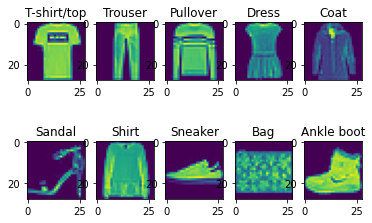

In [10]:
                              """  Question 1 """
#configuring wandb
%pip install wandb -q
import wandb
wandb.login()

wandb.init(project="assignment1_CS910")


image_array=[]
dress=["T-shirt/top", "Trouser","Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag","Ankle boot"]

#creating an array of images from the xtrain array where 1 image for each array is appended
flag = 1
for i in range(0,10,1):
  for j in range(0,len(Y_train),1):
    if Y_train[j]==i and flag:
      image_array.append(X_train[j])
      break;
#printing the images of the array cerated 

dress_number = 0
for i in range(0,len(image_array),1):
  plt.subplot(2,5,i+1)
  print(i+1)  
  plt.imshow(image_array[i])
  dress_number = dress[i]  
  plt.title(dress[i])
wandb.run.name="Question-1"
wandb.log({"Images":[wandb.Image(img,caption=item) for img,item in zip(image_array,dress)]})
wandb.finish()

In [4]:
"""
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

"""
"""    Question 4     """
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize' 
    },
    'parameters': {
        'epochs': {
            'values': [10,20,40,50]
        },
        'learning_rate': {
            'values': [1e-2,1e-3,(1e-3) * 5]
        },
        'algorithm': {
            'values': ['gd','momentum','NAG', 'RMSProp','Adam','Nadam']
        },
        'act_func': {
            'values': ['relu','tanh','sigmoid']
        },
        'hidden_layer': {
            'values': [[32,32,32],[64,64,64],[16,16,16],[128,128,128]]
        },
        'batch_size':{
            'values':[32,64,128]
        },
        
        'loss_function':{
            'values':['cross_entropy','sqaure_error_loss']
        },
        
        'initilisation':{
            'values':['xavier','random']
        },
        'batch':{
            'values':['b','m_B','s']    
        }
    }
}
sweep_id = wandb.sweep(sweep_config, project="assignment1_CS910")

Create sweep with ID: 6bb6jf8c
Sweep URL: https://wandb.ai/cs6910_susmit/assignment1_CS910/sweeps/6bb6jf8c


epoch,▁▁▁▁▁▁▁▁▁▁
loss,█▄▃▂▁▁▁▁▁▁
epoch,10
loss,0.26918


C:\Users\susmi\AppData\Local\Temp\ipykernel_9620\193208404.py:163: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/1 [00:00<?, ?epoch/s]

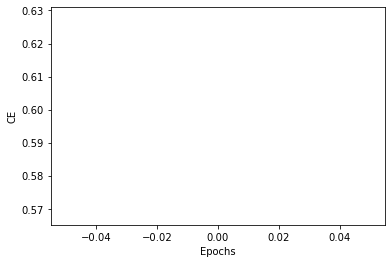

[[9.60814732e-03 3.88360535e-03 1.08461861e-02 8.35443434e-01
  1.84977240e-04 6.66794718e-02 3.27426043e-04 1.74157791e-02
  4.46065928e-02 1.10043804e-02]]
[0 0]
Training accuracy 0.82
Validation accuracy 0.85
Test accuracy 0.83


' For automatic sweeps '

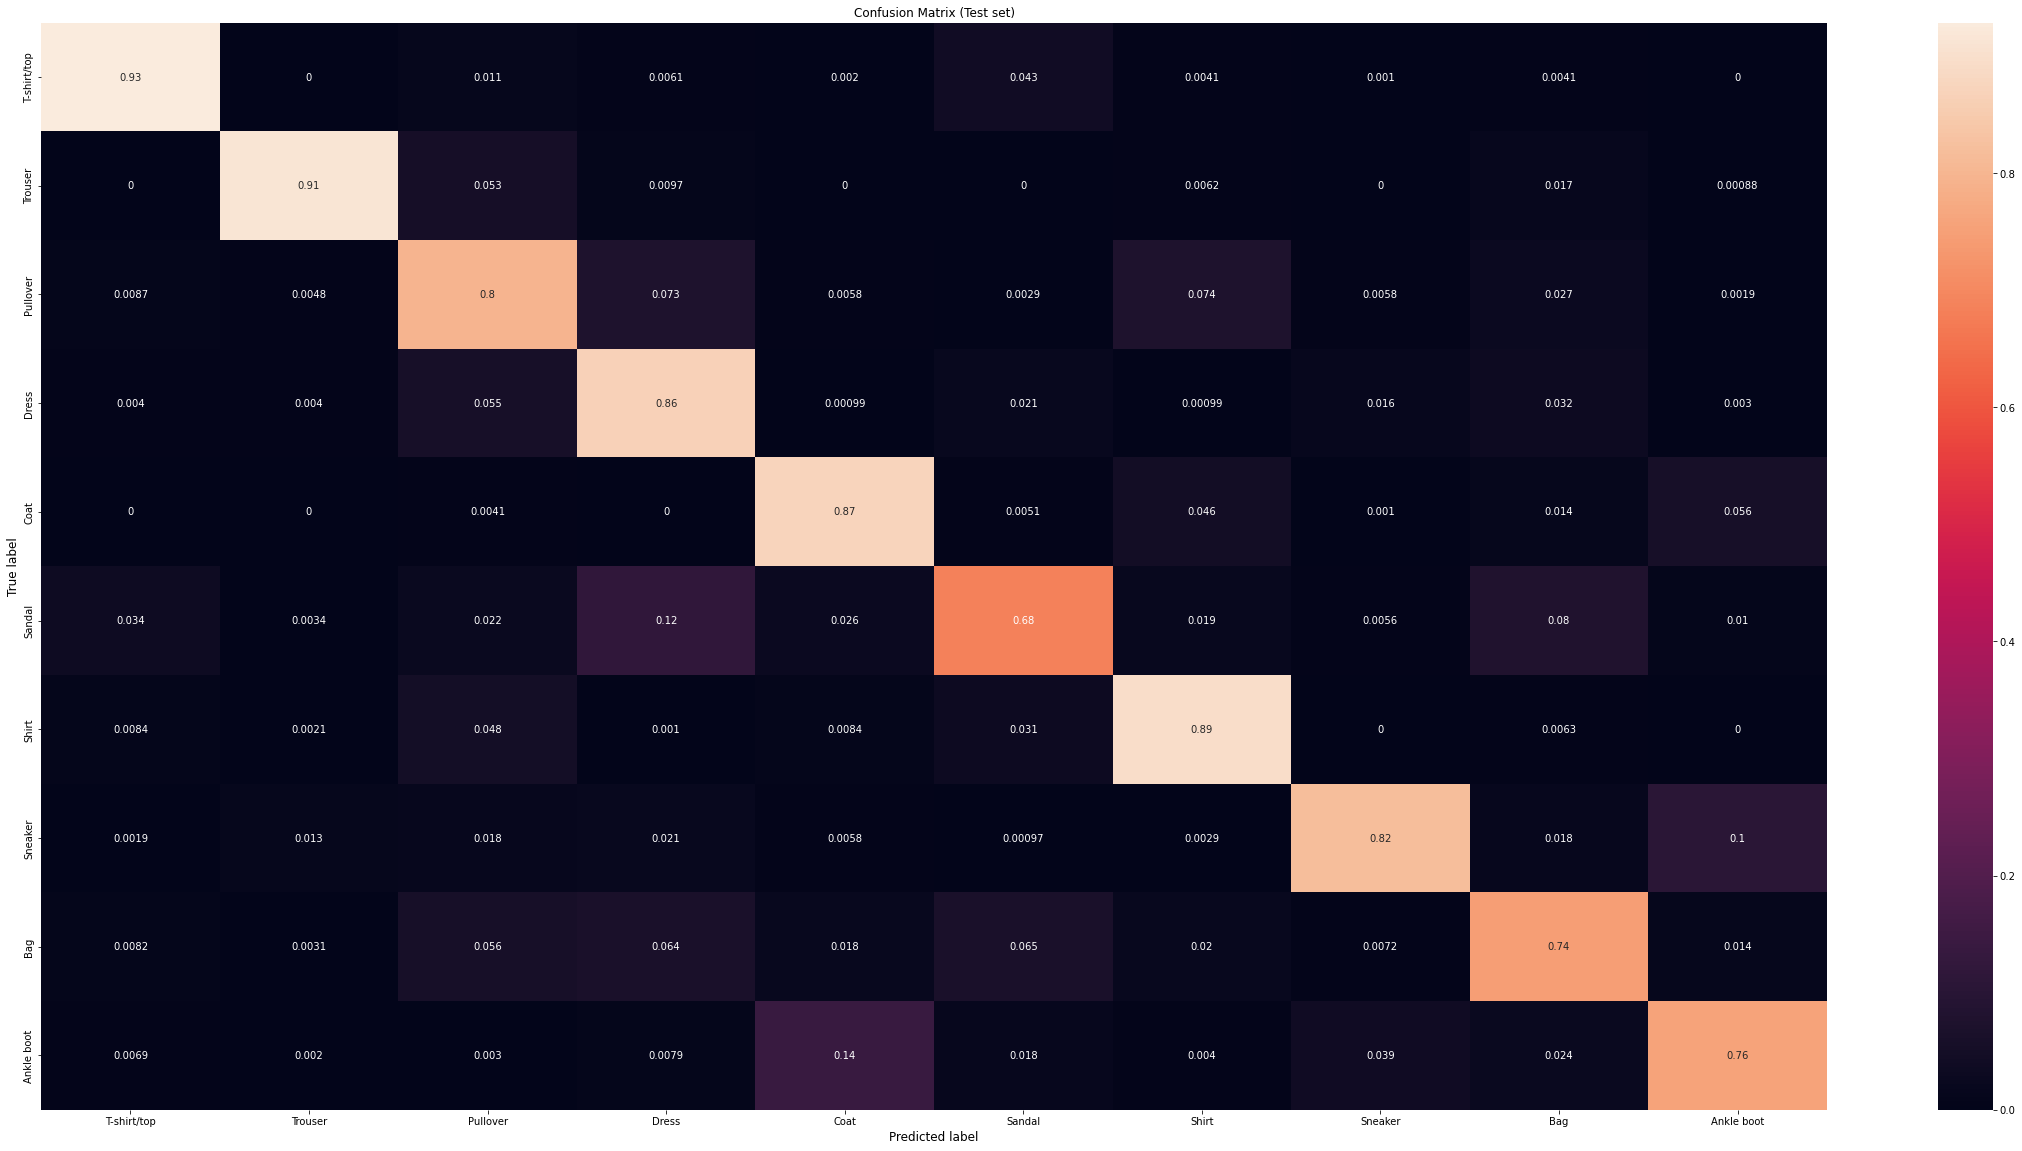

In [9]:
def train():
    #steps = 10
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 20,
        'input_layer': 28*28,
        'output_layer': 10,
        'batch_size':32,
        'learning_rate': 1e-3 + 5,
        'hidden_layer':[128,128,128],
        'learning_rate':(1e-3)*5,
        'algorithm':'Nadam',
        'batch':'m_B',
        'act_func':'tanh',
        'intialize_method':'xavier',
        'loss_function':'cross_entropy'
        
    }

    # Initialize a new wandb run
    wandb.init(project="assignment1_CS910",config=config_defaults)
    
    
    # Config is a variable that holds and saves hyperparameters and inputs
    #config = wandb.config_defaults
    config = wandb.config
    learning_rate = config.learning_rate
    epochs = config.epochs
    hidden_layer = config.hidden_layer
    act_func = config.act_func
    algorithm = config.algorithm
    input_layer = config.input_layer
    output_layer = config.output_layer
    batch_size = config.batch_size
    batch = config.batch
    loss_function = config.loss_function
    intialize_method = config.intialize_method

    # Model training here
    ffsnn = MultiClass_classification(784, [32,32,32], 10)
    enc = OneHotEncoder()
    ffsnn.fit(X1_train, y_train, epochs=1, learning_rate=0.005, batch_size = 32 ,batch = 'm_B',algorithm = "Nadam",act_func = "tanh", intialize_method = "xavier",loss_type = "cross_entropy",l2_norm = False)
    
    """ Question 2 """
    
    print(ffsnn.forward_pass(X_train[0]))
    Y_pred_train = ffsnn.predict(X1_train)
    run_sum = 0
    run_sum+=1
    Y_pred_train = np.argmax(Y_pred_train,1)
    run = 4 ** 2
    Y_pred_val1 = ffsnn.predict(X2_train_validation)
    Y_pred_val1 = np.argmax(Y_pred_val1,1)
    sys = 0
    sys = np.array([0,0])
    Y_pred_val = ffsnn.predict(X_test)
    print(sys)
    Y_pred_val = np.argmax(Y_pred_val,1)

    accuracy_train = accuracy_score(Y_pred_train, Y1_train)
    accuracy_val = accuracy_score(Y_pred_val1, Y2_train_validation)
    accuracy_test = accuracy_score(Y_pred_val, Y_test)
    print("Training accuracy", round(accuracy_train, 2))
    print("Validation accuracy", round(accuracy_val, 2))
    print("Test accuracy", round(accuracy_test, 2))
    wandb.log({"Training accuracys": round(accuracy_train, 2) , "Validation accuracy": round(accuracy_val, 2)})
    
    
    # Confusion matrix  """    Question 7     """
    
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    #accuracy, test_predicted = model.predict(X_test,y_test)
    bern_cnf_matrix_train = confusion_matrix(Y_test, Y_pred_val, normalize='true')
    plt.figure(figsize=(40,20))
    ax = sns.heatmap(bern_cnf_matrix_train, annot=bern_cnf_matrix_train,xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Confusion Matrix (Test set)", size=12)
    ax.set_xlabel("Predicted label", size=12)
    ax.set_ylabel("True label", size=12)
    plt.savefig("Test_confusionmatrix")
    # Load the confusion matrix images
    img1 = plt.imread("Test_confusionmatrix.png")

    #print("Test accuracy ",accuracy_test)
    # Log images of the confusion matrices
    
    
    
    #wandb.log({"Confusion Matrix - Test set": wandb.Image(img1)})
    
    
 
train() 

""" For automatic sweeps """

#wandb.agent(sweep_id, train, count=1)    

[34, 45, 67]
